# 20기 KNN 정규세션 과제

**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

---

## 0. 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Tobigs/Week4/blackfriday.csv", index_col = 0)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


## 1. Preprocssing / EDA

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

%matplotlib inline

'User_ID', 'Product_ID' 변수는 고유식별번호이므로 통계적으로 유의미하지 않다.   -> drop해준다.

In [37]:
df.isna().sum()/len(df)

User_ID                       0.000000
Product_ID                    0.000000
Gender                        0.000000
Age                           0.000000
Occupation                    0.000000
City_Category                 0.000000
Stay_In_Current_City_Years    0.000000
Marital_Status                0.000000
Product_Category_1            0.000000
Product_Category_2            0.306723
Product_Category_3            0.691076
Purchase                      0.000000
dtype: float64

<Axes: >

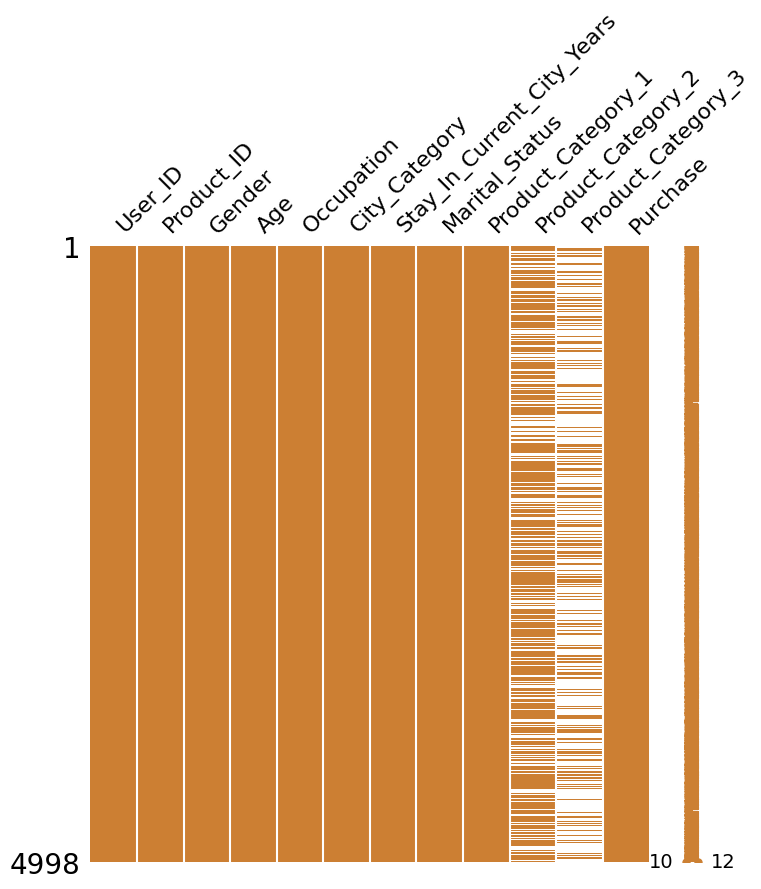

In [38]:
msno.matrix(df=df, figsize=(8,8), color=(0.8, 0.5, 0.2))

In [39]:
df.drop(['Product_Category_3'], axis=1, inplace=True)

<Axes: >

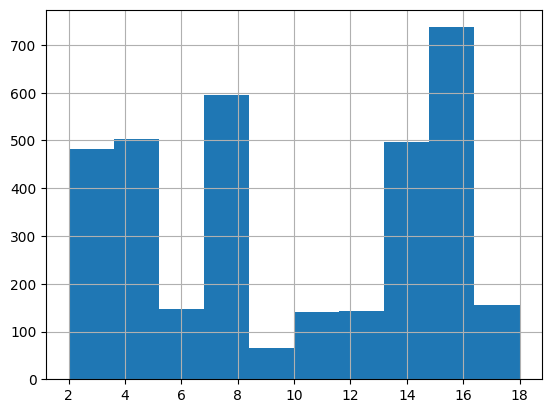

In [40]:
df['Product_Category_2'].hist()

<Axes: xlabel='Product_Category_2', ylabel='Purchase'>

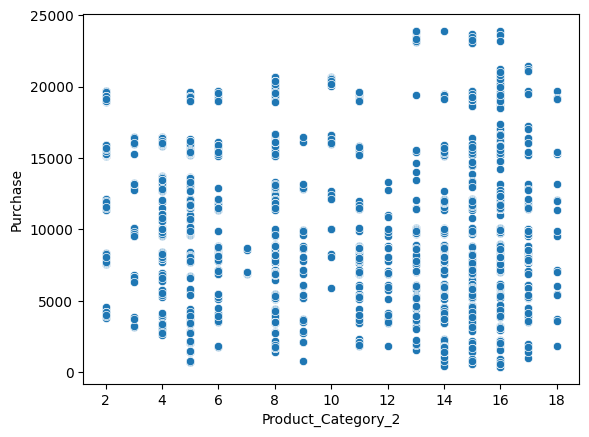

In [41]:
sns.scatterplot(x = 'Product_Category_2', y = 'Purchase', data=df)

In [42]:
df = df.fillna(df.mean()['Product_Category_2'])

<ipython-input-42-f11db5009321>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean()['Product_Category_2'])


여러 plot을 살펴봤을 때 'Product_Category_2' 변수가 타겟 변수인 'Purchase'와 크게 상관관계가 없어 보이므로 해당 변수의 평균값으로 결측치 처리를 진행한다.

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     4998 non-null   int64  
 1   Product_ID                  4998 non-null   object 
 2   Gender                      4998 non-null   object 
 3   Age                         4998 non-null   object 
 4   Occupation                  4998 non-null   int64  
 5   City_Category               4998 non-null   object 
 6   Stay_In_Current_City_Years  4998 non-null   object 
 7   Marital_Status              4998 non-null   int64  
 8   Product_Category_1          4998 non-null   int64  
 9   Product_Category_2          4998 non-null   float64
 10  Purchase                    4998 non-null   int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 468.6+ KB


In [44]:
df.drop(['User_ID', 'Product_ID'], axis=1, inplace=True)

'Product_Category_3' 변수의 결측치가 전체 data의 70%에 거의 육박하고 결측값의 분포가 무작위에 가까우므로 해당 변수는 삭제한다.

In [45]:
df.describe()

,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Purchase
count,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000
mean,8.036815,0.421369,5.320128,9.773737,9234.655462
std,6.442697,0.493828,3.912281,4.247793,4999.225081
min,0.000000,0.000000,1.000000,2.000000,13.000000
25%,2.000000,0.000000,1.000000,8.000000,5497.750000
50%,7.000000,0.000000,5.000000,9.773737,8049.000000
75%,14.000000,1.000000,8.000000,14.000000,12039.000000
max,20.000000,1.000000,20.000000,18.000000,23913.000000


<ipython-input-46-6dc1c4c1753e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

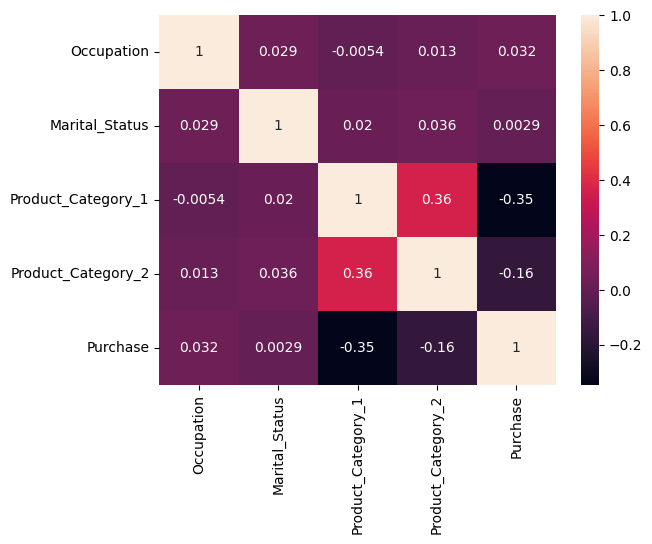

In [46]:
sns.heatmap(df.corr(), annot=True)

변수들 간의 상관계수와 분산을 고려할 때 유클리드 거리보단 변수들 간의 분산을 고려한 거리를 이용하여 모델링을 하는 것이 좋겠다.

<Axes: xlabel='Stay_In_Current_City_Years', ylabel='count'>

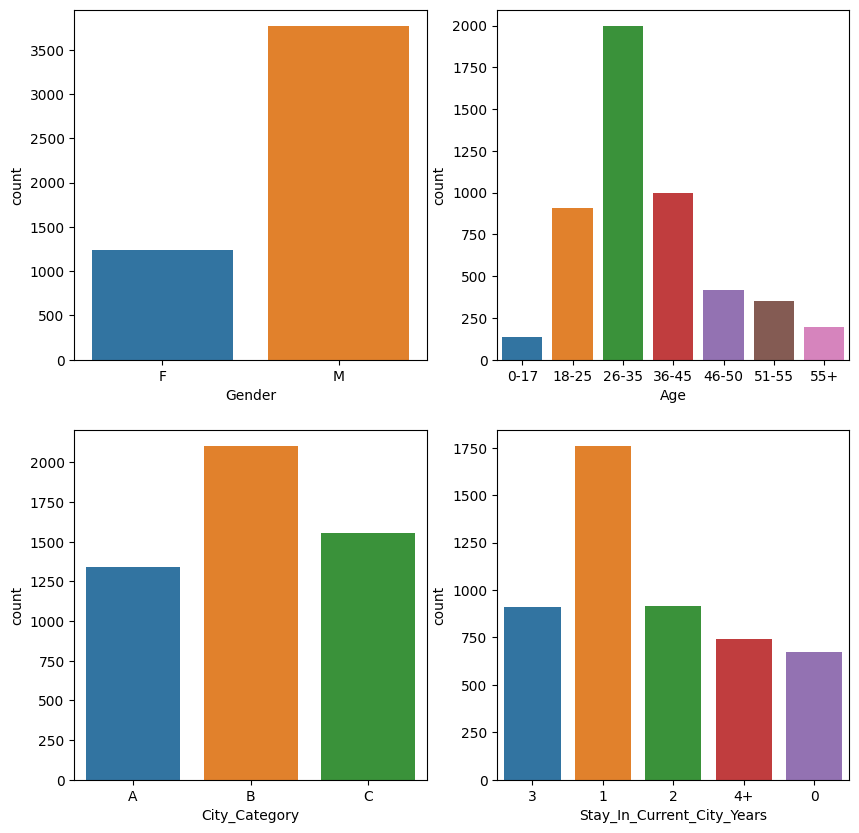

In [47]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
sns.countplot(x = 'Gender', data = df)

plt.subplot(222)
sns.countplot(x = 'Age', data = df)

plt.subplot(223)
sns.countplot(x = 'City_Category', data = df)

plt.subplot(224)
sns.countplot(x = 'Stay_In_Current_City_Years', data = df)

Categorical 변수들만 countplot해봤다.

In [48]:
df

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase
0,F,0-17,10,A,3,0,5,17.000000,2010
1,F,0-17,10,A,1,0,7,9.773737,4483
2,F,0-17,10,A,1,0,1,4.000000,7696
3,F,0-17,10,A,3,0,2,4.000000,16429
4,F,0-17,10,A,3,0,3,5.000000,5780
...,...,...,...,...,...,...,...,...,...
4993,M,55+,7,C,1,1,1,16.000000,11701
4994,M,55+,1,C,1,1,8,9.773737,2045
4995,M,55+,13,C,3,1,1,6.000000,4505
4996,M,55+,0,C,2,1,12,9.773737,1413


In [49]:
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].map({'0':0, '1':1, '2':2, '3':3, '4+':4})

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Gender                      4998 non-null   object 
 1   Age                         4998 non-null   object 
 2   Occupation                  4998 non-null   int64  
 3   City_Category               4998 non-null   object 
 4   Stay_In_Current_City_Years  4998 non-null   int64  
 5   Marital_Status              4998 non-null   int64  
 6   Product_Category_1          4998 non-null   int64  
 7   Product_Category_2          4998 non-null   float64
 8   Purchase                    4998 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 390.5+ KB


In [63]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
df_std = pd.DataFrame(standard_scaler.fit_transform(df[['Occupation', 'Stay_In_Current_City_Years','Marital_Status', 'Product_Category_1', 'Product_Category_2']]), columns=['Occupation', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2'])

In [64]:
df_std

,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2
0,0.304745,0.890850,-0.853356,-0.081835,1.701351e+00
1,0.304745,-0.667592,-0.853356,0.429427,4.182253e-16
2,0.304745,-0.667592,-0.853356,-1.104358,-1.359368e+00
3,0.304745,0.890850,-0.853356,-0.848727,-1.359368e+00
4,0.304745,0.890850,-0.853356,-0.593097,-1.123928e+00
...,...,...,...,...,...
4993,-0.160945,-0.667592,1.171844,-1.104358,1.465911e+00
4994,-1.092325,-0.667592,1.171844,0.685058,4.182253e-16
4995,0.770435,0.890850,1.171844,-1.104358,-8.884884e-01
4996,-1.247555,0.111629,1.171844,1.707582,4.182253e-16


In [65]:
df_std[['Age', 'Gender', 'City_Category']] = df[['Age', 'Gender', 'City_Category']]

In [66]:
df_std = pd.get_dummies(df_std, columns=['Age', 'Gender', 'City_Category'])

In [67]:
df_std

,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Gender_F,Gender_M,City_Category_A,City_Category_B,City_Category_C
0,0.304745,0.890850,-0.853356,-0.081835,1.701351e+00,1,0,0,0,0,0,0,1,0,1,0,0
1,0.304745,-0.667592,-0.853356,0.429427,4.182253e-16,1,0,0,0,0,0,0,1,0,1,0,0
2,0.304745,-0.667592,-0.853356,-1.104358,-1.359368e+00,1,0,0,0,0,0,0,1,0,1,0,0
3,0.304745,0.890850,-0.853356,-0.848727,-1.359368e+00,1,0,0,0,0,0,0,1,0,1,0,0
4,0.304745,0.890850,-0.853356,-0.593097,-1.123928e+00,1,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,-0.160945,-0.667592,1.171844,-1.104358,1.465911e+00,0,0,0,0,0,0,1,0,1,0,0,1
4994,-1.092325,-0.667592,1.171844,0.685058,4.182253e-16,0,0,0,0,0,0,1,0,1,0,0,1
4995,0.770435,0.890850,1.171844,-1.104358,-8.884884e-01,0,0,0,0,0,0,1,0,1,0,0,1
4996,-1.247555,0.111629,1.171844,1.707582,4.182253e-16,0,0,0,0,0,0,1,0,1,0,0,1


In [68]:
df_std.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Occupation                  4998 non-null   float64
 1   Stay_In_Current_City_Years  4998 non-null   float64
 2   Marital_Status              4998 non-null   float64
 3   Product_Category_1          4998 non-null   float64
 4   Product_Category_2          4998 non-null   float64
 5   Age_0-17                    4998 non-null   uint8  
 6   Age_18-25                   4998 non-null   uint8  
 7   Age_26-35                   4998 non-null   uint8  
 8   Age_36-45                   4998 non-null   uint8  
 9   Age_46-50                   4998 non-null   uint8  
 10  Age_51-55                   4998 non-null   uint8  
 11  Age_55+                     4998 non-null   uint8  
 12  Gender_F                    4998 non-null   uint8  
 13  Gender_M                    4998 

df의 변수들을 모두 수치형 변수로 바꿔주었다.

## 2. KNN 구현 & 파라미터 튜닝

In [69]:
from sklearn.model_selection import train_test_split

x = df_std
y = df['Purchase']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3998, 17) (1000, 17) (3998,) (1000,)


In [76]:
X_train

,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Gender_F,Gender_M,City_Category_A,City_Category_B,City_Category_C
1738,1.080895,-0.667592,-0.853356,0.685058,1.701351e+00,0,0,1,0,0,0,0,0,1,1,0,0
3986,0.459975,-0.667592,1.171844,0.685058,1.465911e+00,0,0,0,1,0,0,0,0,1,0,0,1
2915,1.391355,0.890850,1.171844,-1.104358,-1.830248e+00,0,0,1,0,0,0,0,0,1,0,0,1
1595,-0.160945,0.111629,1.171844,-0.081835,4.182253e-16,0,0,1,0,0,0,0,0,1,1,0,0
3213,1.857045,0.890850,1.171844,0.685058,4.182253e-16,0,0,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,-1.247555,1.670071,1.171844,0.685058,1.701351e+00,0,0,0,0,1,0,0,0,1,0,0,1
466,-0.160945,-1.446813,-0.853356,-0.081835,-4.176086e-01,0,1,0,0,0,0,0,0,1,1,0,0
3092,1.391355,0.111629,-0.853356,-0.081835,1.230471e+00,0,0,0,1,0,0,0,1,0,1,0,0
3772,-0.316175,1.670071,-0.853356,0.685058,9.950309e-01,0,0,0,1,0,0,0,0,1,0,1,0


## 3. Evaluation

In [93]:
for k in range(1, 30):
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_regressor.fit(X_train, y_train)
    print(f'Score(R_squared) in X_train data for k={k}: {knn_regressor.score(X_train, y_train)}')

Score(R_squared) in X_train data for k=1: 0.934070479271219
Score(R_squared) in X_train data for k=2: 0.6643573248823966
Score(R_squared) in X_train data for k=3: 0.5478240011377598
Score(R_squared) in X_train data for k=4: 0.48024401114992243
Score(R_squared) in X_train data for k=5: 0.43425914329192994
Score(R_squared) in X_train data for k=6: 0.4026230269467309
Score(R_squared) in X_train data for k=7: 0.3822917651993376
Score(R_squared) in X_train data for k=8: 0.36832183083734316
Score(R_squared) in X_train data for k=9: 0.35713880434610934
Score(R_squared) in X_train data for k=10: 0.3427846200975091
Score(R_squared) in X_train data for k=11: 0.33064572772752365
Score(R_squared) in X_train data for k=12: 0.3202153871109713
Score(R_squared) in X_train data for k=13: 0.31145064487766316
Score(R_squared) in X_train data for k=14: 0.3061831353611547
Score(R_squared) in X_train data for k=15: 0.30141927997807316
Score(R_squared) in X_train data for k=16: 0.2994969602413933
Score(R_squ

In [94]:
for k in range(1, 30):
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_regressor.fit(X_train, y_train)
    print(f'Score(R_squared) in X_test data for k = {k}: {knn_regressor.score(X_test, y_test)}')

Score(R_squared) in X_test data for k = 1: -0.32214582829961236
Score(R_squared) in X_test data for k = 2: -0.07900023856278882
Score(R_squared) in X_test data for k = 3: 0.05774170001451251
Score(R_squared) in X_test data for k = 4: 0.11518454493144781
Score(R_squared) in X_test data for k = 5: 0.14460969556538894
Score(R_squared) in X_test data for k = 6: 0.16259487154364138
Score(R_squared) in X_test data for k = 7: 0.18412291807263514
Score(R_squared) in X_test data for k = 8: 0.19112028559743244
Score(R_squared) in X_test data for k = 9: 0.20401283161498174
Score(R_squared) in X_test data for k = 10: 0.1966938137346932
Score(R_squared) in X_test data for k = 11: 0.20310395643625978
Score(R_squared) in X_test data for k = 12: 0.20370507116762648
Score(R_squared) in X_test data for k = 13: 0.20381534107792387
Score(R_squared) in X_test data for k = 14: 0.2030530862787706
Score(R_squared) in X_test data for k = 15: 0.20790630664793286
Score(R_squared) in X_test data for k = 16: 0.209

In [95]:
for k in range(1, 30):
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_regressor.fit(X_train, y_train)
    print(f'RMSE in X_train data for k={k}: {np.sqrt(mean_squared_error(y_train, knn_regressor.predict(X_train)))}')

RMSE in X_train data for k=1: 1286.740452751204
RMSE in X_train data for k=2: 2903.2844108328572
RMSE in X_train data for k=3: 3369.804831006881
RMSE in X_train data for k=4: 3612.856785181412
RMSE in X_train data for k=5: 3769.2918646996077
RMSE in X_train data for k=6: 3873.2473661855324
RMSE in X_train data for k=7: 3938.607384081399
RMSE in X_train data for k=8: 3982.8956588362075
RMSE in X_train data for k=9: 4017.9969348074837
RMSE in X_train data for k=10: 4062.6073910937525
RMSE in X_train data for k=11: 4099.954292491273
RMSE in X_train data for k=12: 4131.774968627646
RMSE in X_train data for k=13: 4158.325995297368
RMSE in X_train data for k=14: 4174.2016102967455
RMSE in X_train data for k=15: 4188.507457143542
RMSE in X_train data for k=16: 4194.2663615166375
RMSE in X_train data for k=17: 4201.8954082267355
RMSE in X_train data for k=18: 4218.156224636809
RMSE in X_train data for k=19: 4225.464238231153
RMSE in X_train data for k=20: 4233.89930644064
RMSE in X_train data 

In [96]:
for k in range(1, 30):
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_regressor.fit(X_train, y_train)
    print(f'RMSE in X_train data for k={k}: {np.sqrt(mean_squared_error(y_test, knn_regressor.predict(X_test)))}')

RMSE in X_train data for k=1: 5689.265903875473
RMSE in X_train data for k=2: 5139.576362211189
RMSE in X_train data for k=3: 4802.87781710091
RMSE in X_train data for k=4: 4654.17707489063
RMSE in X_train data for k=5: 4576.133802396954
RMSE in X_train data for k=6: 4527.770033713555
RMSE in X_train data for k=7: 4469.191042664963
RMSE in X_train data for k=8: 4449.984771078225
RMSE in X_train data for k=9: 4414.378684708908
RMSE in X_train data for k=10: 4434.627118374216
RMSE in X_train data for k=11: 4416.898181723317
RMSE in X_train data for k=12: 4415.231989836592
RMSE in X_train data for k=13: 4414.9262713934695
RMSE in X_train data for k=14: 4417.039156648642
RMSE in X_train data for k=15: 4403.569250332684
RMSE in X_train data for k=16: 4399.548586257884
RMSE in X_train data for k=17: 4415.187237263771
RMSE in X_train data for k=18: 4406.847099417571
RMSE in X_train data for k=19: 4397.068185451179
RMSE in X_train data for k=20: 4389.6849225152255
RMSE in X_train data for k=21

k값에 상관없이 X_train, X_test데이터에 모두에 대한 평가지표가 굉장히 좋지 않은 것을 볼 수 있다. \

기본적으로 사이킷런의 KNNregressor 메소드는 weights 파라미터를 따로 선언을 하지 않을 경우 uniform으로 설정되어있다. 이 경우 모든 데이터의 이웃의 거리의 가중치가 동일하게 적용된다. \

그래서 weights 파라미터를 distance로 변경해 주었다. 이 경우에는 데이터의 이웃한 데이터들에 더 가중치를 두어 학습을 진행한다.

In [97]:
for k in range(1, 30):
    knn_regressor = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn_regressor.fit(X_train, y_train)
    print(f'Score(R_squared) in X_train data for k={k}: {knn_regressor.score(X_train, y_train)}')

Score(R_squared) in X_train data for k=1: 0.934070479271219
Score(R_squared) in X_train data for k=2: 0.9648052835134432
Score(R_squared) in X_train data for k=3: 0.9675238373506658
Score(R_squared) in X_train data for k=4: 0.967989874611164
Score(R_squared) in X_train data for k=5: 0.9680380234181942
Score(R_squared) in X_train data for k=6: 0.9680449854490704
Score(R_squared) in X_train data for k=7: 0.9680449854490677
Score(R_squared) in X_train data for k=8: 0.968044985449065
Score(R_squared) in X_train data for k=9: 0.968044985449062
Score(R_squared) in X_train data for k=10: 0.9680449854490586
Score(R_squared) in X_train data for k=11: 0.9680449854490556
Score(R_squared) in X_train data for k=12: 0.9680449854490523
Score(R_squared) in X_train data for k=13: 0.9680449854490489
Score(R_squared) in X_train data for k=14: 0.9680449854490453
Score(R_squared) in X_train data for k=15: 0.9680449854490416
Score(R_squared) in X_train data for k=16: 0.9680449854490382
Score(R_squared) in X

In [98]:
for k in range(1, 30):
    knn_regressor = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn_regressor.fit(X_train, y_train)
    print(f'Score(R_squared) in X_test data for k = {k}: {knn_regressor.score(X_test, y_test)}')

Score(R_squared) in X_test data for k = 1: -0.32214582829961236
Score(R_squared) in X_test data for k = 2: -0.07214851742402151
Score(R_squared) in X_test data for k = 3: 0.054548626451065174
Score(R_squared) in X_test data for k = 4: 0.10680002439779102
Score(R_squared) in X_test data for k = 5: 0.13482591831905066
Score(R_squared) in X_test data for k = 6: 0.14936613866442616
Score(R_squared) in X_test data for k = 7: 0.17025048308283297
Score(R_squared) in X_test data for k = 8: 0.17855010646765623
Score(R_squared) in X_test data for k = 9: 0.18837635889044846
Score(R_squared) in X_test data for k = 10: 0.18440673727400658
Score(R_squared) in X_test data for k = 11: 0.19066558593720173
Score(R_squared) in X_test data for k = 12: 0.1939690110671698
Score(R_squared) in X_test data for k = 13: 0.1952693289950762
Score(R_squared) in X_test data for k = 14: 0.19651592117232075
Score(R_squared) in X_test data for k = 15: 0.20094506222171993
Score(R_squared) in X_test data for k = 16: 0.20

In [99]:
for k in range(1, 30):
    knn_regressor = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn_regressor.fit(X_train, y_train)
    print(f'RMSE in X_train data for k={k}: {np.sqrt(mean_squared_error(y_train, knn_regressor.predict(X_train)))}')

RMSE in X_train data for k=1: 1286.740452751204
RMSE in X_train data for k=2: 940.1339383824958
RMSE in X_train data for k=3: 903.0948156575565
RMSE in X_train data for k=4: 896.5916355201729
RMSE in X_train data for k=5: 895.9170667224582
RMSE in X_train data for k=6: 895.8194860555791
RMSE in X_train data for k=7: 895.8194860556167
RMSE in X_train data for k=8: 895.8194860556548
RMSE in X_train data for k=9: 895.8194860556964
RMSE in X_train data for k=10: 895.8194860557437
RMSE in X_train data for k=11: 895.8194860557857
RMSE in X_train data for k=12: 895.8194860558337
RMSE in X_train data for k=13: 895.81948605588
RMSE in X_train data for k=14: 895.8194860559304
RMSE in X_train data for k=15: 895.8194860559826
RMSE in X_train data for k=16: 895.8194860560313
RMSE in X_train data for k=17: 895.819486056085
RMSE in X_train data for k=18: 895.8194860561422
RMSE in X_train data for k=19: 895.8194860562029
RMSE in X_train data for k=20: 895.8194860562659
RMSE in X_train data for k=21: 8

In [100]:
for k in range(1, 30):
    knn_regressor = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn_regressor.fit(X_train, y_train)
    print(f'RMSE in X_train data for k={k}: {np.sqrt(mean_squared_error(y_test, knn_regressor.predict(X_test)))}')

RMSE in X_train data for k=1: 5689.265903875473
RMSE in X_train data for k=2: 5123.23205326578
RMSE in X_train data for k=3: 4811.008799737369
RMSE in X_train data for k=4: 4676.176596241686
RMSE in X_train data for k=5: 4602.2298299305585
RMSE in X_train data for k=6: 4563.393149231706
RMSE in X_train data for k=7: 4507.0259314595
RMSE in X_train data for k=8: 4484.428371382296
RMSE in X_train data for k=9: 4457.526123730502
RMSE in X_train data for k=10: 4468.41362619313
RMSE in X_train data for k=11: 4451.235341620645
RMSE in X_train data for k=12: 4442.141846008738
RMSE in X_train data for k=13: 4438.557288942942
RMSE in X_train data for k=14: 4435.118116405048
RMSE in X_train data for k=15: 4422.877108609447
RMSE in X_train data for k=16: 4423.492125364868
RMSE in X_train data for k=17: 4437.63676944869
RMSE in X_train data for k=18: 4429.719318928439
RMSE in X_train data for k=19: 4421.138628660118
RMSE in X_train data for k=20: 4413.102208804324
RMSE in X_train data for k=21: 44

weight를 distance로 바꾸어 진행하였다. \

X_train 데이터의 평가지표는 uniform의 경우보다 많이 개선되었지만 X_test 데이터의 평가지표는 거의 그대로인 것을 볼 수 있다. k값에 상관없이 X_train 데이터에 대한 과적합이 진행된 것으로 보인다.

scikitlearn의 Knnregressor에서는 데이터 간의 거리를 재는 척도인 metric 척도가 기본적으로 유클리드거리와 맨해튼거리를 이용한 민코우스키 거리로 지정되어 있다. \

입력한 벡터의 차원이 많고 분산을 고려하지 않았으므로 이 부분에서 개선할 여지가 있어 보인다.